In [14]:
from genn import GENN
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from pyDOE2 import lhs, fullfact
%matplotlib inline

# Tutorial 2: Two-Dimensional Rastrigin

Our goal will be to teach a neural network to predict the Rastrigin function, which is a challenging multi-modal function that somewhat ressembles an egg-crate. Mathematically, the Rastrigin function is defined as: 

$$f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n (x_i^2 -10cos(2\pi x_i))$$

## Step 1: Load Training and Test Data

In a first step, let's define the test function we will be working with, taken to be a simple sinusoidal function:

In [15]:
from genn.tests.test_problems import rastrigin

Next, let's define the domain over which we will collect synthetic training data:

In [16]:
# Domain
lb = -1.
ub = 1.5

We will now generate some synthetic data. GENN uses numpy and, therefore, the training data must be provided as numpy arrays where $m$ is the number of samples in the data set, $n_x$ is the number of inputs, and $n_y$ is the number outputs: 

* $X$ = sample inputs of shape $(m, n_x)$
* $Y$ = sample outputs of shape $(m, n_y)$
* $J$ = sample jacobian of shape $(m, n_x, n_y)$

Here's an example below (using pyDOE2): 

In [26]:
# Training Data 
levels = 9
X_train = fullfact([levels] * 2) / (levels - 1)  * (ub - lb) + lb
Y_train, J_train = rastrigin(X_train)

# Test Data 
X_test = lb + (ub - lb) * lhs(2, samples=75, criterion='maximin', iterations=100, random_state=5)
Y_test, J_test = rastrigin(X_test)

## Step 2: Initialize the Model 

We now initalize the model, where $deep \ge 1$ and $wide \ge 1$ are the number of layers in the neural network and the number of nodes per layer, respectively. Feel free to try different network architectures. The parameters $n_x \ge 1$ and $n_y \ge 1$ are the number of inputs and outputs, respectively. 

In [29]:
deep = 2
wide = 24
model = GENN(hidden_layer_sizes=[wide] * deep, activation='tanh',
             num_epochs=1, max_iter=500,
             learning_rate='backtracking', random_state=0, tol=1e-6,
             learning_rate_init=0.05, alpha=0.001, gamma=1, verbose=False)

## Step 3: Train the Model

Now that the model has been initialized, we can train it. To do so, the user only needs to provide training data and tune the hyper-parameters that control the behavior of the training algorithm. They are listed here-under:

In [30]:
model.fit(X_train, Y_train, J_train, is_normalize=True)  

It is good practice to check the convergence history in order to see if we should keep training:

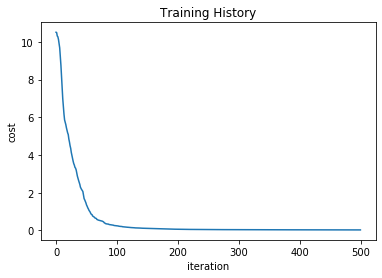

In [31]:
history = model.training_history()

## Step 4: Check Goodness of Fit

Upon convergence, we now check the goodness of fit using the test data we generated earlier:

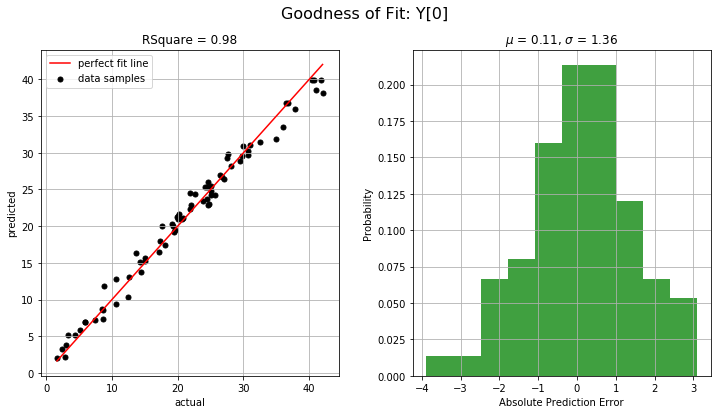

In [32]:
model.goodness_fit(X_test, Y_test)

## Step 5: Plot Results

Finally, since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [33]:
def contour_plot(model, X_train, X_test):
    """Make contour plots of 2D Rastrigin function and compare to Neural Net prediction"""

    if model.gamma == 1: 
        title = 'genn'
    else: 
        title = 'nn'
    # Domain
    lb = -1.
    ub = 1.5
    m = 100
    x1 = np.linspace(lb, ub, m)
    x2 = np.linspace(lb, ub, m)
    X1, X2 = np.meshgrid(x1, x2)

    # True response
    pi = np.pi
    Y_true = np.zeros((m, m))  
    for i in range(m): 
        for j in range(m): 
            x = np.array([[X1[i, j], X2[i, j]]])
            Y_true[i, j] = rastrigin(x)[0]
        
    # Predicted response
    Y_pred = np.zeros((m, m))
    for i in range(0, m):
        for j in range(0, m):
            x = np.array([[X1[i, j], X2[i, j]]])
            Y_pred[i, j] = model.predict(x)

    # Prepare to plot
    fig = plt.figure(figsize=(12, 6))
    spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0)

    # Plot Truth model
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.contour(X1, X2, Y_true, 20, cmap='RdGy')
    anno_opts = dict(xy=(0.5, 1.075), xycoords='axes fraction', va='center', ha='center')
    ax1.annotate('True', **anno_opts)
    anno_opts = dict(xy=(-0.075, 0.5), xycoords='axes fraction', va='center', ha='center')
    ax1.annotate('X2', **anno_opts)
    anno_opts = dict(xy=(0.5, -0.05), xycoords='axes fraction', va='center', ha='center')
    ax1.annotate('X1', **anno_opts)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.scatter(X_train[0, :], X_train[1, :], s=5)
    ax1.set_xlim(lb, ub)
    ax1.set_ylim(lb, ub)
    ax1.plot(X_train[:, 0], X_train[:, 1], 'k.', label='train')
    ax1.plot(X_test[:, 0], X_test[:, 1], 'r+', label='test')
    plt.legend()

    # Plot prediction with gradient enhancement
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.contour(X1, X2, Y_pred, 20, cmap='RdGy')
    anno_opts = dict(xy=(0.5, 1.075), xycoords='axes fraction', va='center', ha='center')
    ax2.annotate(title, **anno_opts)
    anno_opts = dict(xy=(0.5, -0.05), xycoords='axes fraction', va='center', ha='center')
    ax2.annotate('X1', **anno_opts)
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

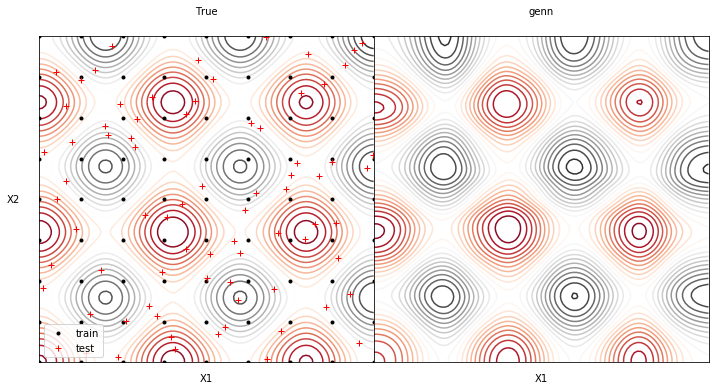

In [34]:
contour_plot(model, X_train, X_test)

As one can see, good agreement is obtained :-) 

## Regular Neural Nets

_Using the exact same inputs, except for $\gamma = 0$, let's compare to regular neural networks:_

In [35]:
model.gamma = 0
model.fit(X_train, Y_train, is_normalize=True)  

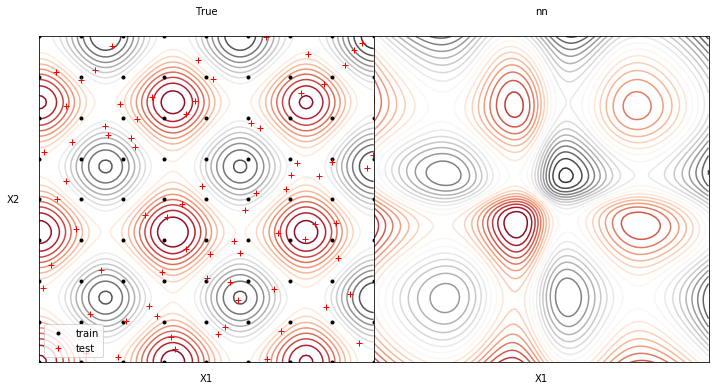

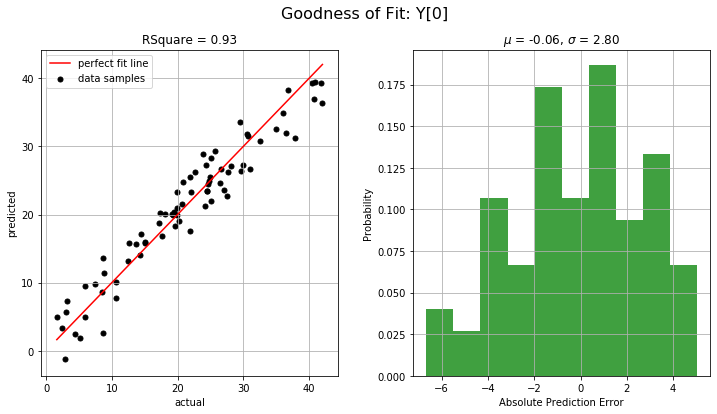

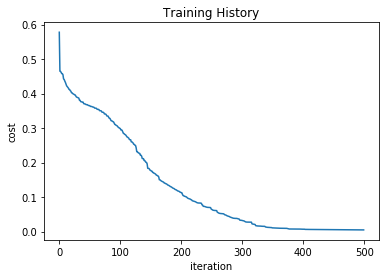

In [36]:
contour_plot(model, X_train, X_test)
model.goodness_fit(X_test, Y_test)
history = model.training_history()

# Conclusions

Everything else being equal, GENN tends to improve the accuracy of the prediction compared to standard Multi-Layer Perceptrons (MLP). 